Cloning into 'Amthal'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 2.84 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Amthal/Amthal
Data loaded successfully. Found 4078 instances.



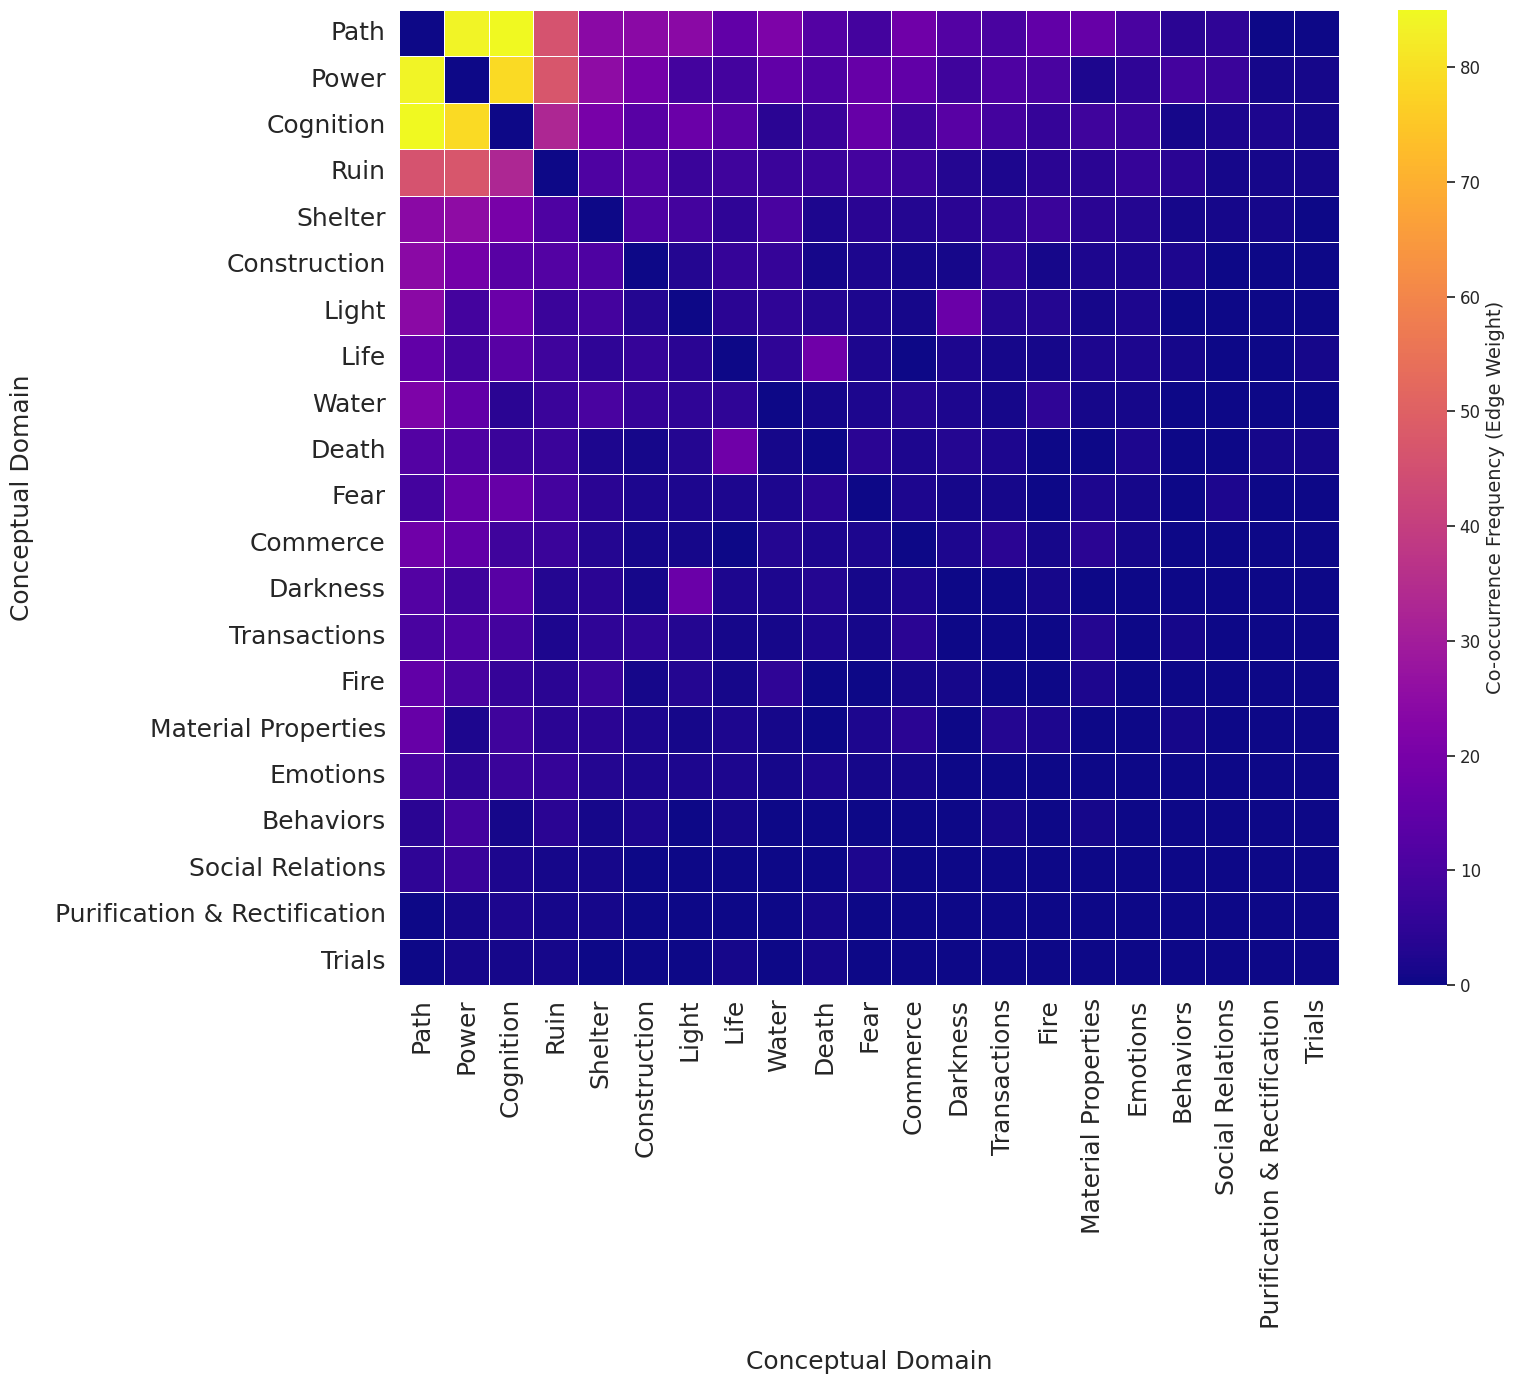

In [2]:
#@title  **Adjacency Matrix of Conceptual Co-occurrence**




# --- إعداد عام ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal

from utility import *
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
import io

import warnings

# تجاهل التحذيرات الخاصة بالخطوط
warnings.filterwarnings("ignore", message=".*font_manager.*")

# تعيين خط متوفر في كل بيئات matplotlib
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]

# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]
    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# (كود بناء edge_weights)
grouped = df.groupby(['Sura_No', 'Aya_No'])['Dominant_Concept'].apply(list)
edges = []
for concepts in grouped:
    if len(concepts) > 1:
        for combo in combinations(set(concepts), 2):
            edges.append(tuple(sorted(combo)))
edge_weights = pd.DataFrame(edges, columns=['source', 'target'])
edge_weights = edge_weights.value_counts().reset_index(name='weight')


# --- 2. بناء مصفوفة التجاور ---

# الخطوة 1: إنشاء مصفوفة غير متماثلة (pivot)
# .fillna(0) لملء الخلايا الفارغة (حيث لا يوجد رابط) بالصفر
adjacency_df = edge_weights.pivot(index='source', columns='target', values='weight').fillna(0)

# الخطوة 2: جعل المصفوفة متماثلة
# نضيف المصفوفة إلى نسختها المنقولة (transposed)
# هذا يضمن أن الخلية (A, B) لها نفس قيمة الخلية (B, A)
all_nodes = pd.unique(edge_weights[['source', 'target']].values.ravel('K'))
adjacency_df = adjacency_df.reindex(index=all_nodes, columns=all_nodes, fill_value=0)
adjacency_matrix = adjacency_df.add(adjacency_df.T, fill_value=0)


# --- 3. فرز المصفوفة بناءً على درجة المركزية ---

# الخطوة 1: حساب درجة المركزية الموزونة (Weighted Degree) لكل عقدة
# هذا هو نفس الحساب الذي قمنا به في الأشكال السابقة
node_degrees = adjacency_matrix.sum(axis=1)

# الخطوة 2: فرز أسماء العقد بناءً on درجتها من الأعلى إلى الأقل
sorted_node_names = node_degrees.sort_values(ascending=False).index

# الخطوة 3: إعادة ترتيب صفوف وأعمدة المصفوفة وفقًا للترتيب الجديد
adjacency_matrix_sorted = adjacency_matrix.loc[sorted_node_names, sorted_node_names]


# --- 4. إعداد الرسم البياني الاحترافي (Heatmap) ---
sns.set_theme(style="white")

# إنشاء لوحة الرسم
fig, ax = plt.subplots(figsize=(16, 14))

# إنشاء الخريطة الحرارية
# cmap='plasma' أو 'viridis' يعطي تدرجًا لونيًا جيدًا
# linewidths=0.5 يضيف خطوطًا بيضاء رفيعة بين الخلايا لتحسين الوضوح
heatmap = sns.heatmap(
    adjacency_matrix_sorted,
    cmap='plasma',
    linewidths=0.5,
    linecolor='white',
    annot=False, # وضعها False لأن الأرقام ستجعل الشكل مزدحمًا جدًا
    cbar_kws={'label': 'Co-occurrence Frequency (Edge Weight)'} # تسمية المفتاح اللوني
)

# --- 5. إضافة التحسينات البصرية ---
#ax.set_title('Adjacency Matrix of Conceptual Co-occurrence', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Conceptual Domain', fontsize=18, labelpad=15)
ax.set_ylabel('Conceptual Domain', fontsize=18, labelpad=15)

# جعل تسميات المحاور أكثر وضوحًا
ax.tick_params(axis='x', labelsize=18, labelrotation=90) # تدوير التسميات السفلية
ax.tick_params(axis='y', labelsize=18, labelrotation=0)

# تعديل حجم تسمية المفتاح اللوني
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(14)

# --- 6. الحفظ والعرض ---
plt.tight_layout()
plt.savefig('Adjacency_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()